In [140]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3  
import pandas as pd  #pandas library
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

## Task 1 - Data Preparation

In [2]:
df = pd.read_csv(filepath_or_buffer='dataset.csv')

In [4]:
# introduce new column Label assigned based on the score column where >3 is positive and <3 is negative
df['Label'] = ''
df.loc[df['Score'] > 3, ['Label']] = "pos"
df.loc[df['Score'] < 3, ['Label']] = "neg"

In [6]:
df.shape

(30365, 11)

In [7]:
# dropping all values of score = 3 as it is less useful,"mixed reviews"
df = df[df['Score'] != 3] 


In [8]:
df.shape

(28054, 11)

In [9]:
df['Label'].value_counts()

pos    23228
neg     4826
Name: Label, dtype: int64

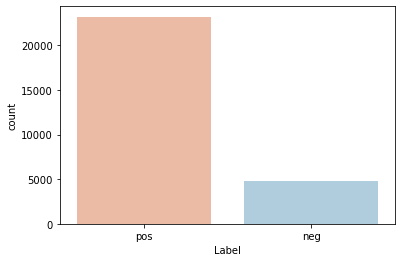

In [11]:
sns.countplot(x='Label', order=["pos","neg"], data=df, palette='RdBu')
plt.xlabel('Label')
plt.show()

It can be observed the total positive reviews is clearly larger than negative reviews

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28054 entries, 0 to 30364
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      28054 non-null  int64 
 1   ProductId               28054 non-null  object
 2   UserId                  28054 non-null  object
 3   ProfileName             28052 non-null  object
 4   HelpfulnessNumerator    28054 non-null  int64 
 5   HelpfulnessDenominator  28054 non-null  int64 
 6   Score                   28054 non-null  int64 
 7   Time                    28054 non-null  int64 
 8   Summary                 28054 non-null  object
 9   Text                    28054 non-null  object
 10  Label                   28054 non-null  object
dtypes: int64(5), object(6)
memory usage: 3.8+ MB


In [17]:
# keep only the relevant columns of the dataset
df = df[['Id', 'Score','Text','Label']]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28054 entries, 0 to 30364
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      28054 non-null  int64 
 1   Score   28054 non-null  int64 
 2   Text    28054 non-null  object
 3   Label   28054 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


## Task 2 - Data Cleaning

In [20]:
df['Text'].iloc[5200]

"Still trying to figure out if Chia seeks are really good for your joints - and supposedly they also have Omega 3.  All good.  Regardless, the blueberry fruit chia bar is a nice treat and makes the chia seeds go down very easily.  It's better than a candy bar."

In [21]:
stop=set(stopwords.words('english'))#set of stop words
#nltk.download('stopwords')

sno=nltk.stem.SnowballStemmer('english') #set of snow ball stemmers in english

def cleanhtml(sentence): #function to clean html tags in a sentence
    cleannr=re.compile('<.*?>')
    cleantext=re.sub(cleannr,'',sentence)
    return cleantext

def cleanpunc(sentence) : #function to clean punctuation in the sentence
    cleaned=re.sub(r'[? | ! | \' |" | #]',r'',sentence)
    cleaned=re.sub(r'[. | , | ) | ( | \ | / ]' ,r' ',sentence)
    return cleaned

print(stop)
print('**' * 40)
print(sno.stem('taste'))

{'mustn', 'm', 'its', 'there', 'our', 'it', 'theirs', 'shouldn', 'from', 'few', 'was', 'haven', "didn't", 'where', 'your', 'up', 'this', 'were', 'below', 'what', "it's", 'had', 'now', 'll', 'or', 'because', 'she', "wouldn't", 'have', 'for', 'off', 'when', 'with', "isn't", 'weren', 'didn', 'most', 'during', "shan't", 'very', 'i', 'through', 'by', 'own', 'himself', 'that', 'each', 'wasn', 'been', 'before', "she's", 'hers', 'their', 'into', 'down', 'herself', 'while', 'doing', 'other', "weren't", 'couldn', 'is', 'an', 'nor', 'of', 'why', 'again', 'does', 'about', 'those', "hadn't", 'they', "that'll", "you've", 'in', 'o', 'ma', 'can', "hasn't", 'them', 'aren', 'my', 'should', 'then', 'him', 'against', 'yourself', 'and', 'how', 'not', 'itself', "doesn't", 'am', "should've", 'who', 'above', 's', 'wouldn', 'ain', 'he', 'won', 'such', "mustn't", "needn't", "you'd", 'between', 've', 'only', 'all', 'after', 'yours', 'shan', 'we', 'at', 'on', 'than', 'over', 're', 'as', 'having', 'hasn', 'isn', '

In [23]:
# printing some random text
sent_0 = df['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = df['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = df['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = df['Text'].values[4900]
print(sent_4900)
print("="*50)

Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
SPECIAL K IS BATTING 1000 IN THE SNACKS DEPARTMENT BUT ESPECIALLY WITH THESE CRISPY CRUNCHY DELICIOUS CHIPS. SOUR CREAM + ONION WAS SPOT ON + GREAT. THESE HOWEVER HAVE A LITTLE SPICY SIGNATURE I'VE NOT TASTED B4. EXCELLENT! A BIT OF ADVICE. COUNT OUT THE 27 CRISPS AHEAD OF TIME + THEN PUT THE BOX ON A HIGH SHELF! ..HIGHLY RECOMMEND!!!
We drink a lot of tea... from all over the world! By far this is the worst tasting tea we have had... I purchased this based on reviews and because this is organic. When compared to st dalfour organic tea... this tastes like Lipton caffeine free tea from Costco! I HAVE always gone with reviews before buying anything online, but this particular tea is no good, At ALL. And Costco returns is better than amazon for so much of something so bad!
Of all the flavors and kinds

In [29]:
# can be observed the last text(4900) contains url,showing url removed from text of row 4900
sent_4900 = re.sub(r"http\S+", "", sent_4900)
print(sent_4900)

Of all the flavors and kinds of coffee, this one is my son's favorite.  I enjoy it, too.  It tastes like a good home brewed coffee, fresh everytime.<a href=" Francisco Bay Coffee One Cup for Keurig K-Cup Brewers, Fog Chaser, 36-Count</a>


In [35]:
# implementing cleaning out html tags cleaning out html tags, can be observed from the following example
from bs4 import BeautifulSoup
soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Of all the flavors and kinds of coffee, this one is my son's favorite.  I enjoy it, too.  It tastes like a good home brewed coffee, fresh everytime.


In [37]:
import re

# \'s such as he's, she's we will just replace with he and she as is is a stop word and will be removed

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [38]:
sent_1500_decontracted = decontracted(sent_1500)
print(sent_1500)
print("="*50)
print(sent_1500_decontracted)

We drink a lot of tea... from all over the world! By far this is the worst tasting tea we have had... I purchased this based on reviews and because this is organic. When compared to st dalfour organic tea... this tastes like Lipton caffeine free tea from Costco! I HAVE always gone with reviews before buying anything online, but this particular tea is no good, At ALL. And Costco returns is better than amazon for so much of something so bad!
We drink a lot of tea... from all over the world! By far this is the worst tasting tea we have had... I purchased this based on reviews and because this is organic. When compared to st dalfour organic tea... this tastes like Lipton caffeine free tea from Costco! I HAVE always gone with reviews before buying anything online, but this particular tea is no good, At ALL. And Costco returns is better than amazon for so much of something so bad!


In [39]:
sent_1500_decontracted = re.sub("\S*\d\S*", "", sent_1500).strip()
print(sent_1500)
print("="*50)
print(sent_1500_decontracted)

We drink a lot of tea... from all over the world! By far this is the worst tasting tea we have had... I purchased this based on reviews and because this is organic. When compared to st dalfour organic tea... this tastes like Lipton caffeine free tea from Costco! I HAVE always gone with reviews before buying anything online, but this particular tea is no good, At ALL. And Costco returns is better than amazon for so much of something so bad!
We drink a lot of tea... from all over the world! By far this is the worst tasting tea we have had... I purchased this based on reviews and because this is organic. When compared to st dalfour organic tea... this tastes like Lipton caffeine free tea from Costco! I HAVE always gone with reviews before buying anything online, but this particular tea is no good, At ALL. And Costco returns is better than amazon for so much of something so bad!


In [40]:
sent_1500_decontracted = re.sub('[^A-Za-z0-9]+', ' ', sent_1500).strip()
print(sent_1500)
print("="*50)
print(sent_1500_decontracted)

We drink a lot of tea... from all over the world! By far this is the worst tasting tea we have had... I purchased this based on reviews and because this is organic. When compared to st dalfour organic tea... this tastes like Lipton caffeine free tea from Costco! I HAVE always gone with reviews before buying anything online, but this particular tea is no good, At ALL. And Costco returns is better than amazon for so much of something so bad!
We drink a lot of tea from all over the world By far this is the worst tasting tea we have had I purchased this based on reviews and because this is organic When compared to st dalfour organic tea this tastes like Lipton caffeine free tea from Costco I HAVE always gone with reviews before buying anything online but this particular tea is no good At ALL And Costco returns is better than amazon for so much of something so bad


In [41]:
# A stop word is a commonly used word (such as “the”, “a”, “an”, “in”
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [49]:
from tqdm import tqdm # tqdm is for printing the status bar
i=0
str1=' '
cleaned_text=[]
all_positive_words=[] #store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here
s=''

for sentance in tqdm(df['Text'].values):
    filtered_sentence=[]
    #print(sentance)
    sentance=cleanhtml(sentance)#removing the html tags
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    # sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    for w in sentance.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stopwords):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (df['Label'].values[i]) == "pos" :
                      all_positive_words.append(s) #list all the positive words
                    if (df['Label'].values[i]) == "neg" :
                       all_negative_words.append(s) #list all the negative words
                else:
                    continue
            else:
                continue
    #print(filtered_sentence)
    str1=b" ".join(filtered_sentence) #final string of the filtered sentence
    
    cleaned_text.append(str1.strip())
    i+=1

100%|██████████| 28054/28054 [00:29<00:00, 940.90it/s] 


In [50]:
df['cleaned_text']=cleaned_text

In [51]:
df['cleaned_text']

0        b'product arriv label jumbo salt peanut peanut...
1        b'great taffi great price wide assort yummi ta...
2        b'healthi dog food good digest also good small...
3        b'love eat good watch look movi not sweet like...
4        b'visit friend nate morn coffe came storag roo...
                               ...                        
30360    b'purchas packet taco season supris best one m...
30361    b'want add hint meyer lemon flavor dish add dr...
30362    b'alway good product exot cat not get raw meat...
30363    b'use product two year seen huge differ lawn l...
30364    b'love coconut flavor tea two thing wish diffe...
Name: cleaned_text, Length: 28054, dtype: object

In [52]:
df['cleaned_text']=df['cleaned_text'].str.decode("utf-8")

In [53]:
df['cleaned_text']

0        product arriv label jumbo salt peanut peanut a...
1        great taffi great price wide assort yummi taff...
2        healthi dog food good digest also good small p...
3        love eat good watch look movi not sweet like t...
4        visit friend nate morn coffe came storag room ...
                               ...                        
30360    purchas packet taco season supris best one mus...
30361    want add hint meyer lemon flavor dish add driz...
30362    alway good product exot cat not get raw meat f...
30363    use product two year seen huge differ lawn loo...
30364    love coconut flavor tea two thing wish differ ...
Name: cleaned_text, Length: 28054, dtype: object

In [60]:
# text added to csv for easier future calls
df.to_csv('text_cleaned.csv',index=False)

In [59]:
df.isnull().values.any()

False

## Task 3 -  logistic regression modelling

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28054 entries, 0 to 30364
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            28054 non-null  int64 
 1   Score         28054 non-null  int64 
 2   Text          28054 non-null  object
 3   Label         28054 non-null  object
 4   cleaned_text  28054 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.5+ MB


In [76]:
# assign cleantext as input data and labels as output/prediction data
X=df['cleaned_text'].values
y=df['Label'].values

In [77]:
# Split the data to 70% training data with 30% test data
import numpy as np
from sklearn.model_selection import train_test_split
random_state = np.random.RandomState(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=random_state)

In [78]:
# Apply Bow Features on Splitted data
from sklearn.feature_extraction.text import CountVectorizer
Vect=CountVectorizer()
Bow_train=Vect.fit_transform(X_train)
Bow_test=Vect.transform(X_test)
print(Bow_train.shape,y_train.shape)
print(Bow_test.shape,y_test.shape)

(19637, 18409) (19637,)
(8417, 18409) (8417,)


In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
import math

In [80]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=random_state)
log_reg.fit(Bow_train, y_train)

LogisticRegression(random_state=RandomState(MT19937) at 0x2B11E377A40)

In [81]:
y_test_log_reg_predictions = log_reg.predict(Bow_test)
y_test_log_reg_predictions

array(['neg', 'pos', 'neg', ..., 'pos', 'neg', 'pos'], dtype=object)

In [82]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_log_reg_predictions)

0.9087560888677676

In [83]:
from sklearn.model_selection import cross_val_score
cross_val_score(LogisticRegression(), Bow_train, y_train, cv=5).mean()

0.9051792073985677

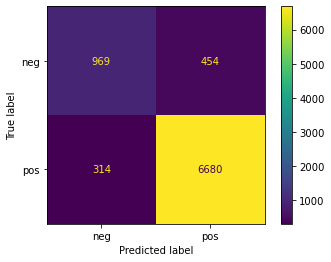

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test, y_test_log_reg_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
display.plot();

In [90]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
# recall_average = recall_score(Y_test, y_predict, average="binary", pos_label="neg")


print("accuracy score",accuracy_score(y_test, y_test_log_reg_predictions))
print("recall score",recall_score(y_test, y_test_log_reg_predictions,average="binary", pos_label="neg"))
print("precision score",precision_score(y_test, y_test_log_reg_predictions,average="binary", pos_label="neg"))
print("f1 score",f1_score(y_test, y_test_log_reg_predictions,average="binary", pos_label="neg"))

accuracy score 0.9087560888677676
recall score 0.6809557273366128
precision score 0.7552611067809821
f1 score 0.7161862527716186


### Baseline Model

In [92]:
# y_train.value_counts()

np.unique(y_train, return_counts=True)


(array(['neg', 'pos'], dtype=object), array([ 3403, 16234], dtype=int64))

In [95]:
y_test_baseline_predictions = pd.Series(["pos"]*len(y_test))

In [96]:
accuracy_score(y_test, y_test_baseline_predictions)

0.8309373886182726

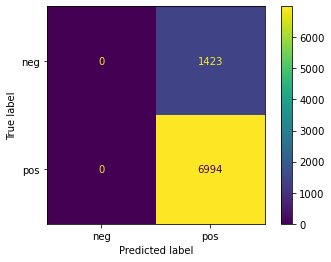

In [97]:
cm = confusion_matrix(y_test, y_test_baseline_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
display.plot();

In [102]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


print("accuracy score",accuracy_score(y_test, y_test_baseline_predictions))
print("recall score",recall_score(y_test, y_test_baseline_predictions,average="binary", pos_label="neg"))
print("precision score",precision_score(y_test, y_test_baseline_predictions,average="binary", pos_label="neg"))
print("f1 score",f1_score(y_test, y_test_baseline_predictions,average="binary", pos_label="neg"))

accuracy score 0.8309373886182726
recall score 0.0
precision score 0.0
f1 score 0.0


### Explain the cause of difference between the accuracy and the f1 score of the negative class for the baseline model.  

accuracy = the measure of all the correctly identified cases. It is most used when all the classes are equally important.

Precision = measure total positive classification from predicted positive reviews, particularly useful instances of high False Positive

Recall = Measure correctly identified positive reviews from all actual positive reviews

F1-Score = harmonic mean of Precision and Recall 


For the baseline it can be determined that the true positives is 0 as the baseline model unable to identify any neg reviews as it is a naive algorithm which identify every prediction as positive.

## Task 5 - Predictdata.csv

In [103]:
predictData = pd.read_csv("predictdata.csv")

In [104]:
predictData.head()

,Id,Text
0,1,"The candy is tasty, but they totally scam you ..."
1,2,I had been looking for the violet candy with t...
2,3,these are very pricey so i only enjoy them now...
3,4,"These candies have a mild flavor, when compare..."
4,5,This product is a bit pricey for the amt. rece...


In [105]:
from tqdm import tqdm # tqdm is for printing the status bar
i=0
str1=' '
cleaned_text=[]
all_positive_words=[] #store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here
s=''

for sentance in tqdm(predictData['Text'].values):
    filtered_sentence=[]
    #print(sentance)
    sentance=cleanhtml(sentance)#removing the html tags
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    # sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    for w in sentance.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stopwords):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
#                     if (df['model_prediction'].values[i]) == 0 :
#                       all_positive_words.append(s) #list all the positive words
#                     if (df['model_prediction'].values[i]) == 1 :
#                        all_negative_words.append(s) #list all the negative words
                else:
                    continue
            else:
                continue
    #print(filtered_sentence)
    str1=b" ".join(filtered_sentence) #final string of the filtered sentence
    
    cleaned_text.append(str1.strip())
    i+=1

100%|██████████| 5/5 [00:00<00:00, 1253.15it/s]


In [106]:
predictData['cleaned_text']=cleaned_text

In [107]:
predictData.head()

,Id,Text,cleaned_text
0,1,"The candy is tasty, but they totally scam you ...",b'candi tasti total scam price jar size soda l...
1,2,I had been looking for the violet candy with t...,b'look violet candi perfect balanc sweet flora...
2,3,these are very pricey so i only enjoy them now...,b'pricey enjoy treat flavor wonderful packag n...
3,4,"These candies have a mild flavor, when compare...",b'candi mild flavor compar choward violet cand...
4,5,This product is a bit pricey for the amt. rece...,b'product bit pricey amt receiv want candi cha...


In [108]:
predictData['cleaned_text']=predictData['cleaned_text'].str.decode("utf-8")

In [109]:
predictData.head()

,Id,Text,cleaned_text
0,1,"The candy is tasty, but they totally scam you ...",candi tasti total scam price jar size soda loo...
1,2,I had been looking for the violet candy with t...,look violet candi perfect balanc sweet floral ...
2,3,these are very pricey so i only enjoy them now...,pricey enjoy treat flavor wonderful packag nic...
3,4,"These candies have a mild flavor, when compare...",candi mild flavor compar choward violet candi ...
4,5,This product is a bit pricey for the amt. rece...,product bit pricey amt receiv want candi chain...


In [110]:
Bow_test_predict=Vect.transform(predictData['cleaned_text'])
print(Bow_test_predict.shape)

(5, 18409)


In [113]:
predict_log_reg_predictions = log_reg.predict(Bow_test_predict)

In [114]:
print(predict_log_reg_predictions)

['neg' 'pos' 'pos' 'pos' 'pos']


In [115]:
predictData['model_prediction']=predict_log_reg_predictions

In [116]:
predictData

,Id,Text,cleaned_text,model_prediction
0,1,"The candy is tasty, but they totally scam you ...",candi tasti total scam price jar size soda loo...,neg
1,2,I had been looking for the violet candy with t...,look violet candi perfect balanc sweet floral ...,pos
2,3,these are very pricey so i only enjoy them now...,pricey enjoy treat flavor wonderful packag nic...,pos
3,4,"These candies have a mild flavor, when compare...",candi mild flavor compar choward violet candi ...,pos
4,5,This product is a bit pricey for the amt. rece...,product bit pricey amt receiv want candi chain...,pos


# Task 6 - Wordcloud

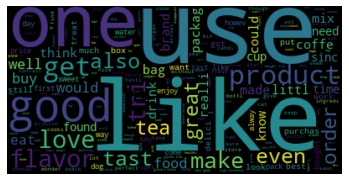

In [117]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

#Creating Stopwords list

stopwords = set(stopwords.words('english'))
stopwords.update(["br","href"])
textt = " ".join(review for review in df['cleaned_text'])
wordcloud = WordCloud(stopwords=stopwords).generate(textt)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Positive wordcloud

There are 4939902 words in the combination of all positive reviews.


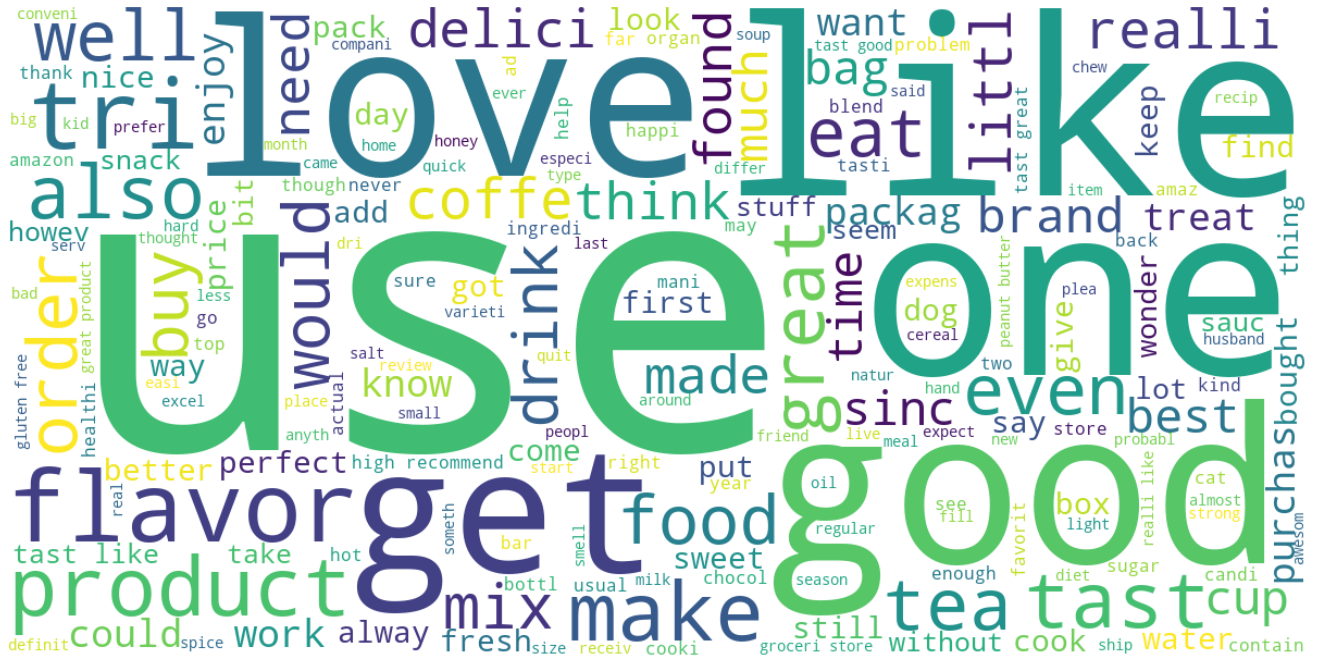

In [118]:
# %%time
df_positive = df[df["Label"] == "pos"]
text = " ".join(review for review in df_positive["cleaned_text"])
print ("There are {} words in the combination of all positive reviews.".format(len(text)))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Negative wordcloud

There are 1150815 words in the combination of all positive reviews.


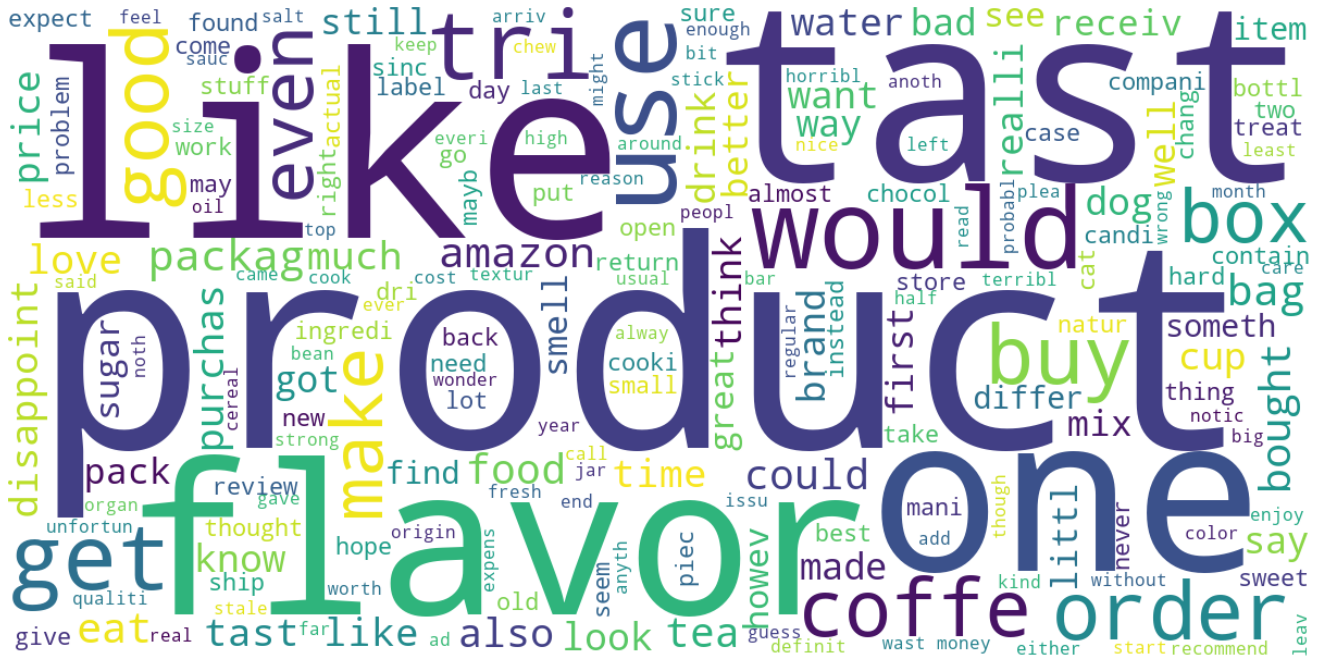

Wall time: 2.51 s


In [119]:
%%time
df_negative = df[df["Label"] == "neg"]
text = " ".join(review for review in df_negative["cleaned_text"])
print ("There are {} words in the combination of all positive reviews.".format(len(text)))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [139]:
Vect.get_feature_names()[::2000]

['aaa',
 'breakroom',
 'danial',
 'follow',
 'ineffici',
 'mexico',
 'philli',
 'scof',
 'teensi',
 'wither']

Determining which words play a significant role in classify can be obtained from using the coefficients for each feature and determine its weight in positive and negativity where smaller weights are negatives and larger weights are positive

In [138]:
feature_names = np.array(Vect.get_feature_names())
sorted_coef_index = log_reg.coef_[0].argsort()
print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['terribl' 'horribl' 'worst' 'cancel' 'disappoint' 'aw' 'weak' 'smash'
 'refund' 'shame']

Largest Coefs: 
['awesom' 'excel' 'perfect' 'best' 'delici' 'beat' 'fantast' 'addict'
 'happi' 'share']



## Task 7 -  classification with unbalanced data

Problem Statement:
Unbalanced data can be described as the distribution of data being modelled is skewed/biased. For example for a binary classification involving only 2 outcomes, There is a higher frequency of Yes data compared to No data. In practice this could lead a problem as most data science algorithms are developed under the impression that the data distribution is equal. This results in poor predictive performance especially for the minority data(s). For example from the existing dataset there is more "pos" labels than "neg" labels, therefore the dataset is biased towards positive which when modelled the dataset might have poor identification of 'neg' labels due to less training.


Solution
Resample the training data in order to a balanced dataset from an imbalanced dataset. This could be achieve by under-sampling the majority data and over-sampling the minority dataset. For example from the dataset provided is to oversample the pos reviews to 1000 and used exactly 1000 of the neg reviews, using this 2000 dataset as the new dataset for training data. Alternatively evaluation metrics could also prove to be useful, not just trying the determine the accuracy of classification but Precision,Recall & F1-score(harmonic mean of precision and recall).

